<a href="https://colab.research.google.com/github/SosiSis/EthioMart-E-commerseLLM/blob/main/notebooks/Fine_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install datasets


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support
from transformers import XLMRobertaTokenizerFast
from datasets import Dataset, Features, Sequence, Value
from transformers import TrainingArguments
from transformers import XLMRobertaForTokenClassification, AutoModelForTokenClassification, AutoTokenizer, Trainer

In [6]:
from google.colab import files

# Upload the file
uploaded = files.upload()

Saving lebeled_conll_data.conll to lebeled_conll_data (1).conll


In [7]:
# Function to load CoNLL formatted data
def load_conll(file_path):
    sentences = []
    labels = []
    with open(file_path, 'r', encoding='utf-8') as f:
        sentence = []
        label = []
        for line in f:
            if line.strip():  # Non-empty line
                token, label_item = line.split()
                sentence.append(token)
                label.append(label_item)
            else:  # Empty line indicates end of a sentence
                sentences.append(sentence)
                labels.append(label)
                sentence = []
                label = []
    return pd.DataFrame({'tokens': sentences, 'labels': labels})

# Load your CoNLL file
df = load_conll('lebeled_conll_data.conll')

In [8]:
# Explore the first few rows
df.head()

,tokens,labels
0,"[እነዚህን, ጫማዎች, እና, ላይ, ማስታወቂያ, አይታችሁ, ስትገቡ, ያጣች...","[O, B-PRODUCT, O, O, O, O, O, O, O, O, B-PRODU..."
1,"[ዛሬ, ሙሉቀን, ክፍት, ነን]","[O, O, O, O]"
2,"[እነዚህን, ጫማዎች, እና, ላይ, ማስታወቂያ, አይታችሁ, ስትገቡ, ያጣች...","[O, B-PRODUCT, O, O, O, O, O, O, O, O, B-PRODU..."
3,"[394041424344, ዋጋ, 3800, ስልክ, 0944222069, በውስጥ...","[O, B-PRICE, I-PRICE, O, O, O, O, O, B-LOCATIO..."
4,"[394041424344, ዋጋ, 3900, ስልክ, 0944222069, በውስጥ...","[O, B-PRICE, I-PRICE, O, O, O, O, O, B-LOCATIO..."


In [9]:
unique_labels = set(label for sublist in df['labels'] for label in sublist)
label2id = {label: i for i, label in enumerate(unique_labels)}
id2label = {i: label for label, i in label2id.items()}

In [10]:
df['labels'] = df['labels'].apply(lambda x: [label2id[label] for label in x])

In [11]:
# Convert DataFrame to Hugging Face Dataset
# Make sure 'labels' is a list of lists
# Define the features with the correct data types
features = Features({
    'tokens': Sequence(Value('string')),  # List of strings for tokens
    'labels': Sequence(Value('int32'))    # List of integers for labels
})

# Convert DataFrame to Hugging Face Dataset with specified features
dataset = Dataset.from_pandas(df[['tokens', 'labels']], features=features)

In [12]:
# Initialize the Fast Tokenizer
# Use the fast tokenizer
# For XLM-Roberta
tokenizer = XLMRobertaTokenizerFast.from_pretrained(
    "xlm-roberta-base",
    clean_up_tokenization_spaces=True
    )

# Define tokenizer function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs

# Tokenize the dataset using xlrm_berta

tokenized_xlm_dataset = dataset.map(tokenize_and_align_labels, batched=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Map:   0%|          | 0/483 [00:00<?, ? examples/s]

In [13]:
# For mBERT
tokenizer_mbert = AutoTokenizer.from_pretrained(
    'bert-base-multilingual-cased',
    clean_up_tokenization_spaces=True
    )
# Define tokenizer function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer_mbert(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs

# Tokenize the dataset using xlrm_berta

tokenized_mbert_dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/483 [00:00<?, ? examples/s]

In [14]:
#Tokenize the dataset using DistilBERT
# For DistilBERT
tokenizer_distilbert = AutoTokenizer.from_pretrained(
    'distilbert-base-multilingual-cased',
    clean_up_tokenization_spaces=True
    )
# Define tokenizer function
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer_distilbert(
        examples['tokens'],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",  # Padding to max length
        max_length=128  # Adjust as needed
    )

    labels = []
    for i, label in enumerate(examples['labels']):
        word_ids = tokenized_inputs.word_ids(batch_index=i)  # Get word ids for each token
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                # Token corresponds to special tokens like [CLS], [SEP], etc.
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # The first token of a word
                label_ids.append(label[word_idx])
            else:
                # Subword token, assign -100 so it's ignored during training
                label_ids.append(-100)
            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs['labels'] = labels
    return tokenized_inputs

tokenized_distilbert_dataset = dataset.map(tokenize_and_align_labels, batched=True)

Map:   0%|          | 0/483 [00:00<?, ? examples/s]

In [15]:
# Split into train and validation datasets
train_test_split_xlm = tokenized_xlm_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation
train_test_split_mbert = tokenized_mbert_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation
train_test_split_distilbert = tokenized_distilbert_dataset.train_test_split(test_size=0.1)  # 90% train, 10% validation

In [16]:
# Set up training arguments with adjustments
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy="epoch",     # Evaluates at the end of each epoch
    learning_rate=2e-5,
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=3,
    weight_decay=0.01,               # Strength of weight decay
    max_grad_norm=1.0,  # Gradient clipping
    logging_dir='./logs',            # Directory for storing logs
    logging_strategy="steps",        # Log at regular intervals
    logging_steps=50,                # Log every 50 steps
    save_strategy="epoch",           # Save model at the end of each epoch
    report_to="none",                # Only show logs in the output (no TensorBoard)
    use_cpu=True,  # Force training to happen on CPU,
    load_best_model_at_end=True,     # Load the best model (based on metric) at the end
    metric_for_best_model="eval_loss",# Metric used to determine the best model
    save_total_limit=1,              # Only keep the best model, delete the others
)


In [17]:
# Initialize each of the models
# For XLM-Roberta
model_xlmr = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=len(unique_labels)) # Ensure unique_labels is defined

# For DistilBERT
model_distilbert = AutoModelForTokenClassification.from_pretrained('distilbert-base-multilingual-cased', num_labels=len(unique_labels))

# For mBERT
model_distilbert = AutoModelForTokenClassification.from_pretrained('bert-base-multilingual-cased', num_labels=len(unique_labels))

Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [18]:
# Define the function to compute evaluation metrics
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Remove ignored index (special tokens)
    true_labels = [[label for label in label_row if label != -100] for label_row in labels]
    predicted_labels = [[pred for pred, true in zip(pred_row, true_row) if true != -100] for pred_row, true_row in zip(predictions, labels)]

    # Flatten the lists
    true_labels_flat = [item for sublist in true_labels for item in sublist]
    predicted_labels_flat = [item for sublist in predicted_labels for item in sublist]

    # Calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels_flat, predicted_labels_flat, average='weighted', zero_division=True)

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

In [19]:
trainer_xlmr = Trainer(
    model=model_xlmr,
    args=training_args,
    train_dataset=train_test_split_xlm['train'],
    eval_dataset=train_test_split_xlm['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)
trainer_distilbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_test_split_mbert['train'],
    eval_dataset=train_test_split_mbert['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)
trainer_mbert = Trainer(
    model=model_distilbert,
    args=training_args,
    train_dataset=train_test_split_distilbert['train'],
    eval_dataset=train_test_split_distilbert['test'],  # Changed from validation to test based on split
    compute_metrics=compute_metrics, # compute f1-score, precision and recall
)

In [20]:
# Fine-tune XLM-Roberta
print('For XLM-Roberta')
trainer_xlmr.train()





For XLM-Roberta


Epoch,Training Loss,Validation Loss,Precision,Recall,F1
1,No log,0.211231,0.927565,0.921332,0.888346
2,0.410200,0.060635,0.979131,0.978030,0.972602
3,0.410200,0.041540,0.986961,0.985826,0.980888


TrainOutput(global_step=84, training_loss=0.25902320941289264, metrics={'train_runtime': 1773.0218, 'train_samples_per_second': 0.734, 'train_steps_per_second': 0.047, 'total_flos': 85054401169920.0, 'train_loss': 0.25902320941289264, 'epoch': 3.0})

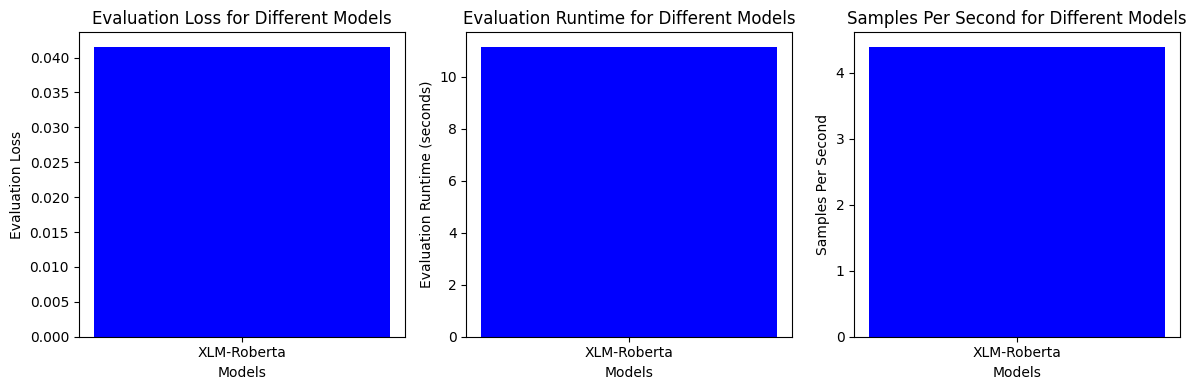

In [21]:
# Create a dictionary to hold the results
results = {}

# Evaluate each model and store the results
results['XLM-Roberta'] = trainer_xlmr.evaluate()



# Extracting the relevant metrics
eval_loss = [results[model]['eval_loss'] for model in results]
eval_runtime = [results[model]['eval_runtime'] for model in results]
samples_per_second = [results[model]['eval_samples_per_second'] for model in results]

# Visualization for Evaluation Loss
plt.figure(figsize=(12, 4))

# Plotting Evaluation Loss
plt.subplot(1, 3, 1)
plt.bar(results.keys(), eval_loss, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Evaluation Loss')
plt.title('Evaluation Loss for Different Models')

# Plotting Evaluation Runtime
plt.subplot(1, 3, 2)
plt.bar(results.keys(), eval_runtime, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Evaluation Runtime (seconds)')
plt.title('Evaluation Runtime for Different Models')

# Plotting Samples Per Second
plt.subplot(1, 3, 3)
plt.bar(results.keys(), samples_per_second, color=['blue', 'orange', 'green'])
plt.xlabel('Models')
plt.ylabel('Samples Per Second')
plt.title('Samples Per Second for Different Models')

plt.tight_layout()
plt.show()

In [22]:
!git clone https://github.com/SosiSis/EthioMart-E-commerseLLM.git


Cloning into 'EthioMart-E-commerseLLM'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (40/40), done.
remote: Total 42 (delta 11), reused 24 (delta 1), pack-reused 0 (from 0)
Receiving objects: 100% (42/42), 169.82 KiB | 878.00 KiB/s, done.
Resolving deltas: 100% (11/11), done.


In [23]:
import os

# Check if the models folder exists, and create it if it doesn't
models_dir = 'models'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)


In [24]:
# Save XLM-Roberta model
xlmr_model_path = os.path.join(models_dir, 'xlmr_model')
trainer_xlmr.save_model(xlmr_model_path)



print("Models saved successfully.")


Models saved successfully.


In [25]:
# Set up Git (if not already done)
!git config --global user.name "SosiSis"
!git config --global user.email "sosinasisay30@gmail.com"



In [26]:
!git init

hint: Using 'master' as the name for the initial branch. This default branch name
hint: is subject to change. To configure the initial branch name to use in all
hint: of your new repositories, which will suppress this warning, call:
hint: 
hint: 	git config --global init.defaultBranch <name>
hint: 
hint: Names commonly chosen instead of 'master' are 'main', 'trunk' and
hint: 'development'. The just-created branch can be renamed via this command:
hint: 
hint: 	git branch -m <name>
Initialized empty Git repository in /content/.git/
